# [Hadoop: The Definitiv Guide]
## Part 1. 하둡 기초
### Ch3. HDFS
- `분산 파일시스템` : 네트워크로 연결된 여러 머신의 스토리지를 관리하는 파일 시스템
- 하둡은 범용 파일시스템을 추구하기 때문에 추상화의 개념을 가지고 있다.

#### 3.1 HDFS 설계<br>

**HDFS 설계의 특성**
- 매우 큰 파일
- 스트리밍 방식의 데이터 접근 : 한 번 쓰고 여러 번 읽기! 전체 데이터 셋을 모두 읽을 때 걸리는 시간이 중요!
- 범용 하드웨어
- 빠른 데이터 응답 시간  <br><br>


**HDFS과 맞지 않는 분야**
- 빠른 데이터 응답 시간 : HBase가 그 대안
- 수많은 작은 파일 : `네임노드`는 파일시스템의 메타데이터를 메모리에서 관리하기 때문
- 다중 writer와 파일의 임의 수정 : HDFS는 단일 writer로 파일을 쓰기 때문에 append는 가능하지만, 수정 X -> 하둡 3.0에서는 다중 writer 지원

#### 3.2 HDFS 개념
##### 3.2.1 블록 <br>

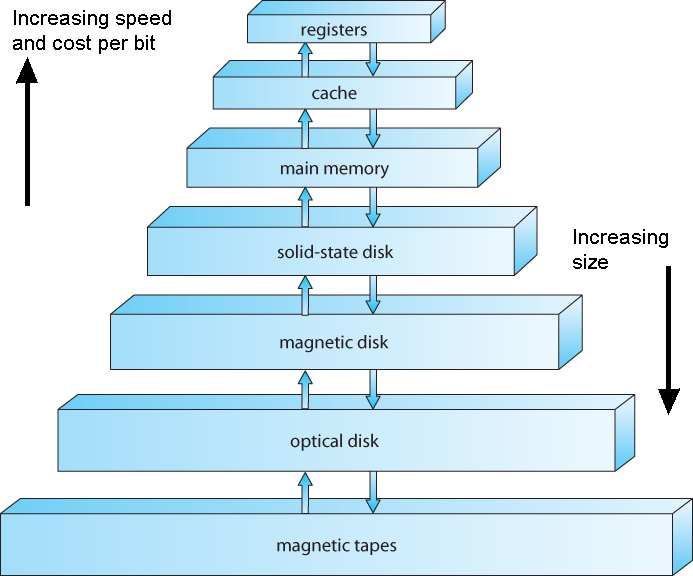

- HDFS도 블록의 개념을 가지고 있다.
- size of file-system : 512 Byte
- size of HDFS's Block : 128 MB

HDFS의 파일은..
1. 특정 블록 크기의 청크로 쪼개진다.
2. 각 청크는 독립적으로 저장된다
3. 블록 크기보다 작은 데이터일 경우 전체 블록 크기에 해당하는 하위 디스크를 모두 점유하지 않는다.<br><br>

_Q. HDFS 블록 사이즈가 큰 이유는?_<br>
A. 탐색 비용을 최소화 하기 위해

**DFS의 블록 추상화 개념 도입으로 얻는 이득**
1. 파일 하나의 크기가 단일 디스크의 용량보다 더 커질 수 있다.
2. 스토리지의 서브 시스템을 단순하게 만들 수 있다.
    - 블록은 고정 크기고 저장에 필요한 디스크 용량만 계산하면 되기 때문이다.
3. 내고장성(fault tolerance)과 가용성(Availability)을 제공하는데 필요한 복제를 구현할 때 적합하다.
    - 장애에 대처하기 위해 각 블록은 다수(3개)의 머신에 복제된다.
    - 특정 블록을 장애로 인해 사용할 수 없다면, 다른 복사본을 살아있는 머신에 복제하여 복제 계수를 정상 수준으로 돌아오게 할 수 있다.

#### 3.2.2 네임노드와 데이터노드<br>
**NameNode**
1. 파일시스템의 네임스페이스를 관리
2. 파일시스템 트리와 그 트리에 포함된 모든 파일과 디렉토리에 대한 <span style="color:red">메타데이터 유지</span> (`Namespace Image`, `Edit Log`)
3. 파일에 속한 모든 블록이 어느 데이터노드에 있는지 파악
    - but, 블록의 위치 정보는 디스크에 영속적으로 저장하지 X
    - 그 이유는 시스템이 시작할 때 모든 데이터노드로부터 받아서 재구성하기 때문
4. 네임노드가 없으면 파일시스템은 동작하지 X --> `네임노드 장애 복구 기능` 필수적<br>

<br><br>**DataNode**
1. 파일시스템의 실질적 일꾼
2. 클라이언트나 네임노드의 요청이 있을 때 블록을 저장하고 탐색
3. 저장하고 있는 블록의 목록을 주기적으로 네임노드에 보고

`Namespace Image`<br>
현 상황을 snapshot(image) 형식으로 저장하여 관리<br><br>

`Edit Log`<br>
변경 로그 : 상태가 변경되는 이력들을 log로 저장<br><br>


`네임노드 장애 복구 기능`<br>
1. 메타데이터를 파일로 백업
    - 지속적인 상태로 보존하기 위해
    - 권장 방법 : 로컬 디스크와 원격의 `NFS 마운트` 두 곳에 동시에 백업
    - `NFS` : Network File System의 약자로 어떤 한 시스템(클라이언트)에서 다른 시스템(서버)의 자원을 자신의 자원처럼 사용이 가능하도록 하는 것을 말한다. 이렇게 사용함으로써 자원의 낭비를 줄이고 효율적인 운영을 할 수 있기 때문이다.<br><br>

2. 보조 네임노드(Secondary NameNode) 운영
    - Edit Log가 너무 커지지 않도록 주기적으로 새로운 Namespace image를 만든다.
    - 주 네임노드에 장애가 발생할 것을 대비하여 Namespace Image 복제본을 보관하고 있다.


#### 3.2.3 블록 캐싱<br>
빈번하게 접근하는 블록 파일은 off-heap 블록 캐시라는 데이터노드의 메모리에 명시적으로 캐싱할 수 있다.
--> 여기 잘 모르겠음.<br><br>


#### 3.2.4 HDFS 페더레이션<br>
- 클러스터에서 확장성에 가장 큰 걸림돌은 **메모리**이다.
- 하둡 2.X 버전부터 HDFS federation(연합체)를 지원한다.
- `HDFS federation`를 활용하면 각각의 네임노드가 FS의 NameSpace를 일부 나누어 관리하는 방식으로 새로운 네임노드를 추가할 수 있다.
- `Namespace Volume` : 네임스페이스의 메타데이터를 구성함. 서로 독립되어 있음. -> NameNode와 통신 X, 특정 네임노드에 장애 발생 시 다른 네임노드가 관리하는 네임스페이스의 가용성에 영향을 주지 않는다.
- `Block Pool` : 네임스페이스에 포함된 파일의 전체 블록을 보관. 저장소가 분리 X<br><br>

#### 3.2.5 HDFS 고가용성(High Availability)<br>
- Standby NameNode가 추가됨.
- `QJM(Quuorum Journal Manager)` : HDFS 전용 구현체로, 고가용성 Edit Log를 지원하기 위한 목적으로 설계되고, HDFS의 권장 옵션이다. 한 번에 하나의 네임노드만 Edit Log에 쓸 수 있도록 보장한다.
- `JournalNodes(저널 노드)` : QJM이 동작하는 그룹. 각 Edit Log는 전체 저널 노드에 동시에 쓰여진다.<br>

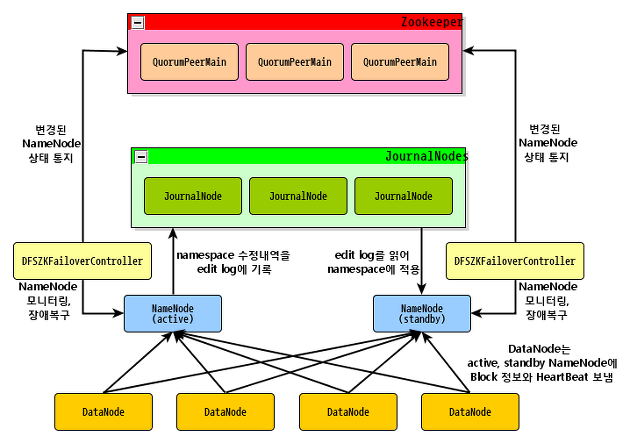<br><br>

- 장애 복구와 펜싱 : 장애에 대한 처리 방법 설명... 노드를 확실히 죽이는 방법..?